# AlexNet Model Implementation
---
- 구현에 쓰인 학습 데이터셋은 Dogs-vs-Cats 데이터셋을 이용함. 
- 이 경우 out_features는 class가 2개이므로 2임. 

In [1]:
# 필요한 라이브러리 호출

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# 데이터 전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# 데이터를 가져와서 훈련, 검증, 테스트 용도로 분리

dog_vs_cat_directory = './dogs-vs-cats/train/'

dog_vs_cat_images_filepaths = sorted([os.path.join(dog_vs_cat_directory, f) for f in os.listdir(dog_vs_cat_directory)])

images_filepaths = [*dog_vs_cat_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:20000]
val_images_filepaths = correct_images_filepaths[20000:-500]
test_images_filepaths = correct_images_filepaths[-500:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4500 500


In [4]:
# 커스텀 데이터셋 정의

class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 이미지 데이터가 위치한 파일 경로
        self.transform = transform  # 이미지 데이터 전처리
        self.phase = phase  # self.phase는 ImageTransform()에서 정의한 train과 val을 의미
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]  # 이미지 데이터의 인덱스를 가져오기
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]  # 레이블 값을 가져오기
        
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
            
        
        return img_transformed, label  # 전처리가 적용된 이미지와 레이블 반환

In [5]:
# 전처리에서 필요한 평균(mean), 표준편차(std) 등에 대한 변수 값 정의

size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 512

In [6]:
# 훈련, 검증, 테스트 데이터셋 정의

train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
1


In [7]:
# 데이터셋을 메모리로 불러옴

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([512, 3, 256, 256])
tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0

In [8]:
# AlexNet 모델 네트워크 정의

class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 2),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
# model 객체 생성

model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# 옵티마이저 및 손실 함수 정의

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
# 모델 네트워크 구조 확인

from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [12]:
# 모델 학습 함수 정의
import time

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    
    return model

In [13]:
## 모델 학습
num_epoch = 200
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/200
--------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.4893


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.5071
Epoch 2/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.4947


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5071
Epoch 3/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5029


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5269
Epoch 4/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5093


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5684
Epoch 5/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5152


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5860
Epoch 6/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5202


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5780
Epoch 7/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5234


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5778
Epoch 8/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5245


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5829
Epoch 9/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5266


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5902
Epoch 10/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5331


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6928 Acc: 0.5973
Epoch 11/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5416


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.5916
Epoch 12/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5284


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6926 Acc: 0.5316
Epoch 13/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5403


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6925 Acc: 0.5893
Epoch 14/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6926 Acc: 0.5544


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6925 Acc: 0.5867
Epoch 15/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6926 Acc: 0.5439


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.5349
Epoch 16/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6925 Acc: 0.5525


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.5827
Epoch 17/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6924 Acc: 0.5546


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6921 Acc: 0.5469
Epoch 18/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6923 Acc: 0.5561


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6920 Acc: 0.5536
Epoch 19/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6922 Acc: 0.5502


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6919 Acc: 0.5389
Epoch 20/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6921 Acc: 0.5604


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6918 Acc: 0.5669
Epoch 21/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6920 Acc: 0.5615


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6916 Acc: 0.5580
Epoch 22/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6919 Acc: 0.5340


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6913 Acc: 0.5269
Epoch 23/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6918 Acc: 0.5438


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6911 Acc: 0.5333
Epoch 24/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6916 Acc: 0.5279


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6909 Acc: 0.5240
Epoch 25/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6914 Acc: 0.5441


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6907 Acc: 0.5340
Epoch 26/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6912 Acc: 0.5499


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6904 Acc: 0.5360
Epoch 27/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6909 Acc: 0.5512


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6900 Acc: 0.5362
Epoch 28/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6906 Acc: 0.5535


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6896 Acc: 0.5413
Epoch 29/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6903 Acc: 0.5500


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6891 Acc: 0.5411
Epoch 30/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6898 Acc: 0.5665


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6886 Acc: 0.5484
Epoch 31/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6894 Acc: 0.5659


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6880 Acc: 0.5520
Epoch 32/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6889 Acc: 0.5637


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6872 Acc: 0.5516
Epoch 33/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6881 Acc: 0.5533


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6863 Acc: 0.5482
Epoch 34/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6872 Acc: 0.5580


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6851 Acc: 0.5598
Epoch 35/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6863 Acc: 0.5977


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6837 Acc: 0.5791
Epoch 36/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6849 Acc: 0.5935


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6819 Acc: 0.5891
Epoch 37/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6831 Acc: 0.6032


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6795 Acc: 0.5920
Epoch 38/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6809 Acc: 0.6027


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6764 Acc: 0.5927
Epoch 39/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6782 Acc: 0.6067


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6725 Acc: 0.6140
Epoch 40/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6746 Acc: 0.6142


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6677 Acc: 0.6249
Epoch 41/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6702 Acc: 0.6197


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6633 Acc: 0.6122
Epoch 42/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6651 Acc: 0.6251


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6591 Acc: 0.6138
Epoch 43/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6615 Acc: 0.6202


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6522 Acc: 0.6280
Epoch 44/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6558 Acc: 0.6276


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6448 Acc: 0.6487
Epoch 45/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6510 Acc: 0.6329


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6415 Acc: 0.6378
Epoch 46/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6475 Acc: 0.6346


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6335 Acc: 0.6527
Epoch 47/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6406 Acc: 0.6389


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6286 Acc: 0.6562
Epoch 48/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6370 Acc: 0.6407


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6286 Acc: 0.6440
Epoch 49/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6353 Acc: 0.6405


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6183 Acc: 0.6667
Epoch 50/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6293 Acc: 0.6469


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6181 Acc: 0.6582
Epoch 51/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6236 Acc: 0.6526


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6134 Acc: 0.6638
Epoch 52/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6207 Acc: 0.6570


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6066 Acc: 0.6760
Epoch 53/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6265 Acc: 0.6515


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6075 Acc: 0.6700
Epoch 54/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6141 Acc: 0.6648


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5922 Acc: 0.6878
Epoch 55/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6177 Acc: 0.6606


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5926 Acc: 0.6867
Epoch 56/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6059 Acc: 0.6708


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5803 Acc: 0.6958
Epoch 57/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6067 Acc: 0.6746


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5779 Acc: 0.7029
Epoch 58/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5939 Acc: 0.6894


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5673 Acc: 0.7127
Epoch 59/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5867 Acc: 0.6934


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5612 Acc: 0.7109
Epoch 60/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5810 Acc: 0.6986


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5632 Acc: 0.7084
Epoch 61/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5763 Acc: 0.7042


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5754 Acc: 0.7042
Epoch 62/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5834 Acc: 0.6995


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5452 Acc: 0.7296
Epoch 63/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5706 Acc: 0.7087


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5598 Acc: 0.7164
Epoch 64/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5637 Acc: 0.7135


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5691 Acc: 0.7027
Epoch 65/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5507 Acc: 0.7282


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5567 Acc: 0.7189
Epoch 66/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5646 Acc: 0.7108


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6854 Acc: 0.6300
Epoch 67/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5626 Acc: 0.7160


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5148 Acc: 0.7504
Epoch 68/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5440 Acc: 0.7291


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4997 Acc: 0.7631
Epoch 69/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5553 Acc: 0.7216


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.8041 Acc: 0.5907
Epoch 70/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5762 Acc: 0.7042


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5668 Acc: 0.7053
Epoch 71/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5377 Acc: 0.7350


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5544 Acc: 0.7109
Epoch 72/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5300 Acc: 0.7414


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5817 Acc: 0.7076
Epoch 73/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5352 Acc: 0.7358


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4984 Acc: 0.7567
Epoch 74/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5139 Acc: 0.7541


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 1.0052 Acc: 0.5504
Epoch 75/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.6075 Acc: 0.6928


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5156 Acc: 0.7624
Epoch 76/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5368 Acc: 0.7354


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4857 Acc: 0.7709
Epoch 77/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5153 Acc: 0.7554


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6345 Acc: 0.6844
Epoch 78/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5494 Acc: 0.7283


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4832 Acc: 0.7824
Epoch 79/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5100 Acc: 0.7584


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5359 Acc: 0.7413
Epoch 80/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4934 Acc: 0.7677


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4673 Acc: 0.7811
Epoch 81/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4907 Acc: 0.7704


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4578 Acc: 0.7884
Epoch 82/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.5137 Acc: 0.7500


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4999 Acc: 0.7622
Epoch 83/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4940 Acc: 0.7689


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4674 Acc: 0.7782
Epoch 84/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4978 Acc: 0.7624


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4907 Acc: 0.7687
Epoch 85/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4911 Acc: 0.7700


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4387 Acc: 0.8013
Epoch 86/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4707 Acc: 0.7825


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5586 Acc: 0.7291
Epoch 87/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4963 Acc: 0.7634


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5882 Acc: 0.7084
Epoch 88/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4794 Acc: 0.7739


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4631 Acc: 0.7849
Epoch 89/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4536 Acc: 0.7941


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5189 Acc: 0.7544
Epoch 90/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4745 Acc: 0.7812


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4547 Acc: 0.7831
Epoch 91/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4476 Acc: 0.7928


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5499 Acc: 0.7504
Epoch 92/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4583 Acc: 0.7883


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4118 Acc: 0.8169
Epoch 93/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4459 Acc: 0.7984


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5381 Acc: 0.7447
Epoch 94/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4549 Acc: 0.7933


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4531 Acc: 0.7860
Epoch 95/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4496 Acc: 0.7942


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5569 Acc: 0.7391
Epoch 96/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4800 Acc: 0.7721


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6385 Acc: 0.6896
Epoch 97/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4745 Acc: 0.7777


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5266 Acc: 0.7516
Epoch 98/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4351 Acc: 0.8021


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4369 Acc: 0.7967
Epoch 99/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4234 Acc: 0.8090


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3828 Acc: 0.8284
Epoch 100/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4432 Acc: 0.7991


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5471 Acc: 0.7296
Epoch 101/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4477 Acc: 0.7967


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4005 Acc: 0.8258
Epoch 102/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4182 Acc: 0.8149


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3733 Acc: 0.8404
Epoch 103/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4122 Acc: 0.8164


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3766 Acc: 0.8338
Epoch 104/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4092 Acc: 0.8156


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3637 Acc: 0.8427
Epoch 105/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3962 Acc: 0.8236


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3614 Acc: 0.8449
Epoch 106/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3936 Acc: 0.8261


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3753 Acc: 0.8380
Epoch 107/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3937 Acc: 0.8238


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6267 Acc: 0.7153
Epoch 108/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4412 Acc: 0.7990


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3619 Acc: 0.8453
Epoch 109/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3991 Acc: 0.8238


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3899 Acc: 0.8264
Epoch 110/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3864 Acc: 0.8272


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3469 Acc: 0.8524
Epoch 111/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3990 Acc: 0.8241


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3632 Acc: 0.8440
Epoch 112/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3944 Acc: 0.8247


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3662 Acc: 0.8364
Epoch 113/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3629 Acc: 0.8445


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3442 Acc: 0.8520
Epoch 114/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3661 Acc: 0.8392


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4266 Acc: 0.8098
Epoch 115/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3773 Acc: 0.8345


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5211 Acc: 0.7693
Epoch 116/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4060 Acc: 0.8155


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4369 Acc: 0.8122
Epoch 117/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3551 Acc: 0.8431


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3119 Acc: 0.8667
Epoch 118/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3519 Acc: 0.8456


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3511 Acc: 0.8482
Epoch 119/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3765 Acc: 0.8329


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3295 Acc: 0.8600
Epoch 120/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3632 Acc: 0.8421


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3881 Acc: 0.8298
Epoch 121/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3428 Acc: 0.8539


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3499 Acc: 0.8496
Epoch 122/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3477 Acc: 0.8498


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.6641 Acc: 0.7189
Epoch 123/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.4202 Acc: 0.8093


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3234 Acc: 0.8616
Epoch 124/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3485 Acc: 0.8493


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5725 Acc: 0.7516
Epoch 125/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3664 Acc: 0.8382


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3066 Acc: 0.8660
Epoch 126/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3198 Acc: 0.8646


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3146 Acc: 0.8656
Epoch 127/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3152 Acc: 0.8650


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5105 Acc: 0.7773
Epoch 128/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3430 Acc: 0.8508


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3236 Acc: 0.8589
Epoch 129/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3487 Acc: 0.8474


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3055 Acc: 0.8671
Epoch 130/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3224 Acc: 0.8626


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3319 Acc: 0.8536
Epoch 131/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3089 Acc: 0.8683


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2744 Acc: 0.8836
Epoch 132/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3162 Acc: 0.8644


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4251 Acc: 0.8136
Epoch 133/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3257 Acc: 0.8603


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3443 Acc: 0.8560
Epoch 134/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.3090 Acc: 0.8690


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2673 Acc: 0.8878
Epoch 135/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2951 Acc: 0.8757


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2948 Acc: 0.8749
Epoch 136/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2943 Acc: 0.8759


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2474 Acc: 0.8973
Epoch 137/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2854 Acc: 0.8800


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2800 Acc: 0.8827
Epoch 138/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2945 Acc: 0.8770


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2782 Acc: 0.8840
Epoch 139/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2899 Acc: 0.8791


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2501 Acc: 0.8949
Epoch 140/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2705 Acc: 0.8864


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.5057 Acc: 0.7989
Epoch 141/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2971 Acc: 0.8725


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2390 Acc: 0.9002
Epoch 142/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2737 Acc: 0.8846


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3567 Acc: 0.8576
Epoch 143/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2906 Acc: 0.8766


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2587 Acc: 0.8947
Epoch 144/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2738 Acc: 0.8846


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2465 Acc: 0.8949
Epoch 145/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2702 Acc: 0.8868


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4326 Acc: 0.8151
Epoch 146/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2893 Acc: 0.8787


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4035 Acc: 0.8258
Epoch 147/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2733 Acc: 0.8839


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2441 Acc: 0.9002
Epoch 148/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2700 Acc: 0.8855


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2701 Acc: 0.8831
Epoch 149/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2801 Acc: 0.8793


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2322 Acc: 0.9036
Epoch 150/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2467 Acc: 0.8974


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4291 Acc: 0.8273
Epoch 151/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2839 Acc: 0.8800


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2331 Acc: 0.9009
Epoch 152/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2378 Acc: 0.9002


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4497 Acc: 0.8229
Epoch 153/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2794 Acc: 0.8821


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2394 Acc: 0.9053
Epoch 154/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2371 Acc: 0.9014


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2435 Acc: 0.8964
Epoch 155/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2395 Acc: 0.9022


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2005 Acc: 0.9169
Epoch 156/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2354 Acc: 0.8997


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2022 Acc: 0.9196
Epoch 157/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2430 Acc: 0.8992


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2417 Acc: 0.8956
Epoch 158/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2300 Acc: 0.9030


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2760 Acc: 0.8887
Epoch 159/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2664 Acc: 0.8842


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2554 Acc: 0.8938
Epoch 160/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2286 Acc: 0.9082


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2611 Acc: 0.8864
Epoch 161/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2270 Acc: 0.9068


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2044 Acc: 0.9158
Epoch 162/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2248 Acc: 0.9077


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2341 Acc: 0.8942
Epoch 163/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2203 Acc: 0.9089


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2019 Acc: 0.9173
Epoch 164/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2226 Acc: 0.9093


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2102 Acc: 0.9138
Epoch 165/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2319 Acc: 0.9022


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2138 Acc: 0.9082
Epoch 166/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2299 Acc: 0.9062


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2052 Acc: 0.9162
Epoch 167/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2236 Acc: 0.9073


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1974 Acc: 0.9222
Epoch 168/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2210 Acc: 0.9103


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1945 Acc: 0.9204
Epoch 169/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2059 Acc: 0.9158


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1919 Acc: 0.9236
Epoch 170/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2117 Acc: 0.9124


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3982 Acc: 0.8462
Epoch 171/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2383 Acc: 0.9009


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1900 Acc: 0.9202
Epoch 172/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1999 Acc: 0.9172


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1949 Acc: 0.9224
Epoch 173/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2062 Acc: 0.9162


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4516 Acc: 0.8084
Epoch 174/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2658 Acc: 0.8882


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1887 Acc: 0.9224
Epoch 175/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1984 Acc: 0.9189


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2951 Acc: 0.8704
Epoch 176/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2134 Acc: 0.9117


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.3218 Acc: 0.8660
Epoch 177/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2373 Acc: 0.8985


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2325 Acc: 0.8958
Epoch 178/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2156 Acc: 0.9129


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1650 Acc: 0.9298
Epoch 179/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1943 Acc: 0.9214


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1772 Acc: 0.9251
Epoch 180/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1921 Acc: 0.9214


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2330 Acc: 0.9016
Epoch 181/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2068 Acc: 0.9148


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1670 Acc: 0.9329
Epoch 182/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1961 Acc: 0.9199


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1785 Acc: 0.9260
Epoch 183/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1852 Acc: 0.9249


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2998 Acc: 0.8798
Epoch 184/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2125 Acc: 0.9128


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2886 Acc: 0.8782
Epoch 185/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2031 Acc: 0.9169


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1844 Acc: 0.9240
Epoch 186/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1917 Acc: 0.9228


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1646 Acc: 0.9347
Epoch 187/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1838 Acc: 0.9252


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1606 Acc: 0.9318
Epoch 188/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1798 Acc: 0.9281


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1752 Acc: 0.9302
Epoch 189/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1829 Acc: 0.9242


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.4715 Acc: 0.8287
Epoch 190/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.2303 Acc: 0.9040


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1712 Acc: 0.9278
Epoch 191/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1822 Acc: 0.9257


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1750 Acc: 0.9233
Epoch 192/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1816 Acc: 0.9261


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1527 Acc: 0.9380
Epoch 193/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1707 Acc: 0.9324


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1783 Acc: 0.9213
Epoch 194/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1679 Acc: 0.9306


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2323 Acc: 0.9062
Epoch 195/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1800 Acc: 0.9261


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1580 Acc: 0.9413
Epoch 196/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1696 Acc: 0.9346


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1601 Acc: 0.9362
Epoch 197/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1696 Acc: 0.9318


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1738 Acc: 0.9291
Epoch 198/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1610 Acc: 0.9348


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1578 Acc: 0.9322
Epoch 199/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1734 Acc: 0.9297


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.1643 Acc: 0.9313
Epoch 200/200
--------------------


  0%|          | 0/40 [00:00<?, ?it/s]

train Loss: 0.1629 Acc: 0.9336


  0%|          | 0/9 [00:00<?, ?it/s]

val Loss: 0.2038 Acc: 0.9227
Training complete in 204m 21s


In [14]:
# 모델을 이용한 예측

import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):  # 테스트 이미지 데이터 사용
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]  # 이미지 데이터의 번호 가져오기
        
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')  # 테스트 데이터에 검증용 전처리 적용
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
        
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})  # 데이터 프레임에 이미지의 id(번호)와 레이블 저장

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
res.head(10)

id     label
0   6066  0.000012
1   9176  0.707421
2   7254  0.989165
3   1089  0.997598
4   8545  0.001492
5    922  0.996035
6   4037  0.116709
7  10728  0.000008
8  10906  0.997679
9    397  0.004759

In [16]:
# 예측 결과를 시각적으로 표현하기 위한 함수 정의

import matplotlib.pyplot as plt

class_ = classes = {0:'cat', 1:'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 100))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        
        if label > 0.5:
            label = 1
        else:
            label = 0
        
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

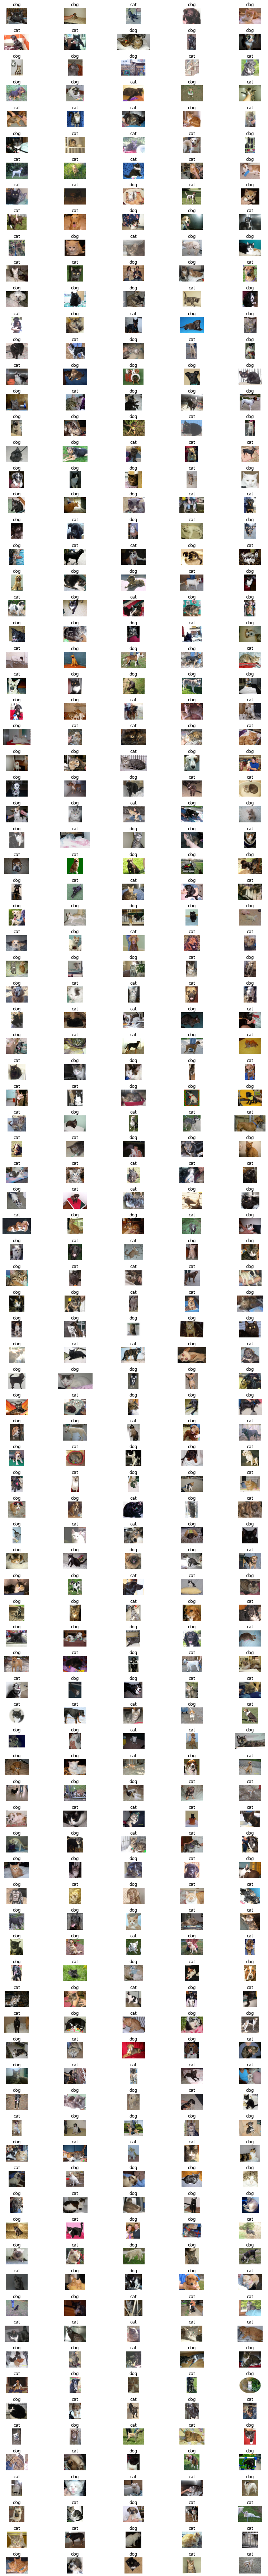

In [17]:
display_image_grid(test_images_filepaths)

## 회고 / TIL
---
- '딥러닝 파이토치 교과서 (한빛미디어)'을 토대로 AlexNet을 구현했음. 
    - 신간이라 코드에 오기된 부분이 있었고, 수정해서 구현함. 
    - 책에서는 Dogs vs Cats 데이터의 일부 500장만 추려서 train, validation, test셋을 나누는데, AlexNet 모델 크기에 비해 데이터가 너무 적다고 판단해 Kaggle에서 Dogs vs Cats 전체 데이터셋 (25000장)을 받아서 구현에 사용함.
    - 책에서는 500장의 이미지로 10 epoch 학습해 val acc가 50%에 그쳤지만, 25000장의 이미지에 대해 배치 사이즈 512, 200 epoch 학습해 val acc가 92% 언저리까지 나왔음. 
- 모델 구축 부분은 실제 AlexNet과 많이 상이하기에, PyTorch에서의 전체적인 흐름(데이터 전처리, 모델 구축 등)만 익히는데 집중했음. 
    - 모델 구축 부분에 `nn.AdaptiveAvgPool2d`가 들어가 있는데, 왜 들어가있는지 정확한 이유를 모르겠음. 
    - 찾아보니 몇몇 reference에서도 그런 경우가 있었는데, 논문에 없는 계층을 왜 사용하는건지 아직 잘 모르겠음. 
    - 책에서는 입력 크기에 변동이 있고 CNN 위쪽에 완전연결층을 사용하는 경우 유용하다고만 나와 있음... -> 공부 필요
    - 애초에 PyTorch에 대해 주로 다루는 책이기에 모델은 예제에 맞게 맞춰서 구현한 것 같음 (class도 2개).
- 여기에도 LRN 계층을 제외하고 구현되어 있는데, LRN을 포함한 경우 초기 loss가 큰 것 같다는 무성님의 추측을 들어서 이에 대해 LRN 유무에 대한 ablation study를 진행할 예정임. 
- 추가로, 책에서는 LeNet-5에 대한 구현부터 시작하기 때문에, 그것도 다른 reference들과 비교하면서 살펴볼 예정임. 

## Reference
---
- https://www.gilbut.co.kr/book/view?bookcode=BN003345